In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow.python.ops import parallel_for as pfor
import sys
import json
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
from numpy import linalg as LA
from sklearn import linear_model
from sklearn.manifold import MDS
from sklearn.neighbors import DistanceMetric
from scipy.spatial import distance
from sklearn.cluster import KMeans

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from tools_lnd import get_T_inds, plot_N, plot_N3D, out_axes, plot_FP_jitter, make_FP_axs, comp_eig_decomp
from tools_lnd import make_lil_axes, same_stim_trial, generate_Beta_epoch, gen_X_from_model_dir_epoch, make_D_use
from tools_lnd import make_h_trial_rule, get_model_params, gen_trials_from_model_dir, gen_X_from_model_dir
from tools_lnd import interp2d,gen_D_fp_qr,gen_mov_trial_set

In [6]:
##################################################################
#Find right model dir
##################################################################

rule_trains = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
          'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
          'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']##################

rnn_type = 'LeakyRNN'
activation = 'softplus'
w_init = 'diag'
ruleset = 'mem_motifs_small'
rule_trains = rules_dict[ruleset]
n_tasks = str(len(rule_trains))
rule_trains_str = '_'.join(rule_trains)
n_rnn = str(256)
l2w = -6
l2h = -6
l1w = 0
l1h = 0
seed = '0'
lr = -7
net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
# net_name = 'lr7.0l2_w6.0_h-0.0_fdgo_fdanti'
data_folder = 'data_share/rnn/multitask/stepnet/final'
m = os.path.join(p,data_folder,ruleset,rnn_type,activation,w_init,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,seed)

In [7]:
epoch_set_master = ['stim1','stim1']
figpath = os.path.join(p,'code','overleaf','multitask-nets','online_figs','fig2','fig2_ACEGI')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [8]:
model = Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    trial = generate_trials('delaygo', hparams, mode='test', noise_on=False, batch_size = 128, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
    
    n_input = hparams['n_input']
    n_rnn = hparams['n_rnn']
    n_output = hparams['n_output']
    w_in = params[0]
    b_in = params[1]
    w_out = params[2]
    b_out = params[3]
    sigma_rec = 0#hparams['sigma_rec']
    dt = hparams['dt']
    tau = hparams['tau']
    alpha = dt/tau
    activation = hparams['activation']

if activation == 'softplus':
    _activation = lambda x: np.log(np.exp(x) + 1)
elif activation == 'tanh':
    _activation = lambda x: np.tanh(x)
elif activation == 'relu':
    _activation = lambda x: x * (x > 0)
elif activation == 'power':
    _activation = lambda x: (x * (x > 0))**2
elif activation == 'retanh':
    _activation = lambda x: np.tanh(x * (x > 0))

def out_affine(params, h):
    offset = np.repeat(params[3][:,np.newaxis],np.shape(h)[1],axis = 1)
    return np.dot(params[2].T,h)+offset

def relu(x):
    f = x * (x > 0)
    return f

def rnn_vanilla(params, h, x, alpha):
    alpha = .2
    xh = np.concatenate([x,h], axis=0)
    gate_inputs = np.dot(params[0].T,xh)+params[1]
    noise = 0
    output = _activation(gate_inputs) # + noise
    
#     print(type(alpha),type(h),type(output))

    h_new = (1-alpha) * h + alpha * output
    
    return h_new

def vanilla_run_with_h0(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(np.expand_dims(h0,axis=1))
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))

    h_t = np.squeeze(np.array(h_t))  
    return h_t

def vanilla_run_at_fp(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(h)
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))
        
    return h_t

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data_share/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data_share/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt


/usr/local/Caskroom/miniconda/base/envs/tensorflow/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


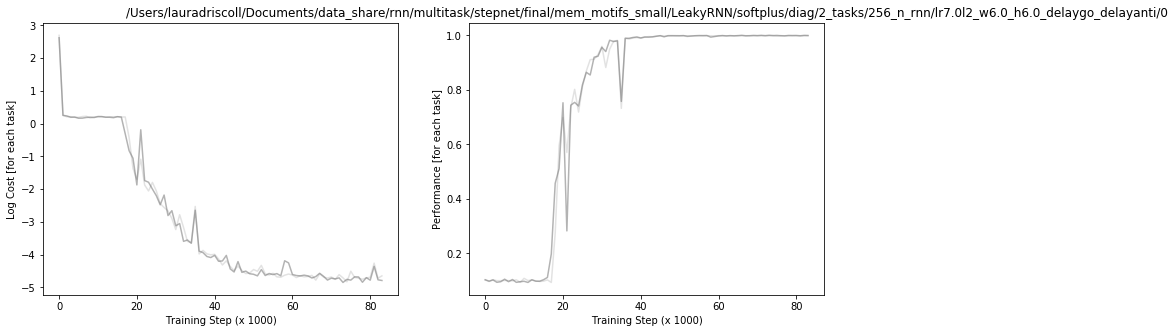

In [9]:
fig = plt.figure(figsize=(14, 5))
cmap=plt.get_cmap('Greys')
fname = os.path.join(m, 'log.json')
task_list = hparams['rule_trains']

with open(fname, 'r') as f:
    log_all = json.load(f)
for r in range(len(task_list)):
    c = cmap((r+1)/(len(task_list)+1))
    
    ax1 = fig.add_subplot(1,2,1)
    x = np.log(log_all['cost_'+task_list[r]])
    plt.plot(x,'-',c = c,alpha = .5)

    ax2 = fig.add_subplot(1,2,2)
    x = log_all['perf_'+task_list[r]]
    plt.plot(x,'-',c = c,alpha = .5)

ax1.set_xlabel('Training Step (x 1000)')
ax1.set_ylabel('Log Cost [for each task]')    
ax2.set_xlabel('Training Step (x 1000)')
ax2.set_ylabel('Performance [for each task]')
plt.title(m)
plt.show()    

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) 

/usr/local/Caskroom/miniconda/base/envs/tensorflow/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


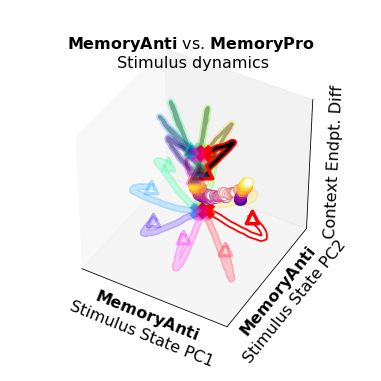

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

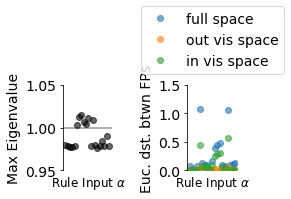

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

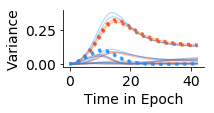

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

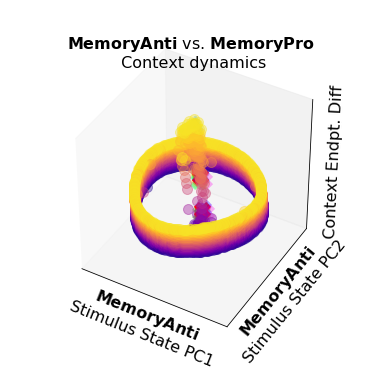

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

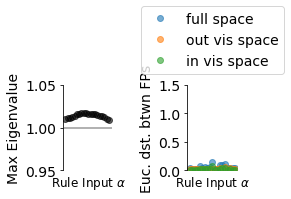

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

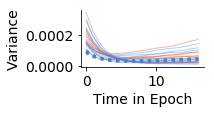

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

KeyboardInterrupt: 

In [ ]:
from tools_lnd import make_D_use, interp3d,take_names, find_fp_dst_subspaces, plot_var_in

interp = True
fig_size = 5
linestyle = ['-','-']
tol_q = 1e-6
interp = True
trial_num = [0,0]
t_set = [0,0]

axs = 'pca_h'

rule_set = [5,2]
rule_str = [rules_dict['all'][rule_set[0]],rules_dict['all'][rule_set[1]]]
rule_axs = 0
trial_set = gen_mov_trial_set(m,rule_set)
D_fp_qr = gen_D_fp_qr(m,trial_set,rule_axs, ['fix1','fix1'],trial_num)

rule = rules_dict['all'][rule_set[rule_axs]]
D_stim = make_FP_axs(' ', m, rule, epoch_set_master[0], axs = axs)

D_use = -D_stim
D_use[:,2] = D_fp_qr[:,0]

epoch_name_ax, rule_name_ax, _, _ = take_names(epoch_set_master[0],rules_dict['all'][rule_set[rule_axs]])
ax_labels = [r"$\bf{"+rule_name_ax+"}$"+'\n '+epoch_name_ax+' State PC1',
             r"$\bf{"+rule_name_ax+"}$"+'\n '+epoch_name_ax+' State PC2',
             r"$\bf{"+rule_name_ax+"}$"+'\n '+epoch_name_ax+' State PC3']

script_name = 'interp_tasks_small_init_stim'
epoch_set = ['stim1','stim1']
q_thresh = .000001

interp3d(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
         interp = interp,q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True,
         n_skip_interps=1,lil_axes =False,color_stim = True,fig_size = fig_size,fontsize = 16,
         figpath = figpath,ruleset = ruleset,alpha_fp = .6,plot_zero_plane = False, 
         ax_labels = ax_labels, stability_thresh = 1, z_label = 'Context Endpt. Diff',view_ang = [40, -60])

_, _, _,f = find_fp_dst_subspaces(m, D_use, trial_set, epoch_set, rule_set, trial_num, q_thresh = q_thresh, 
                      script_name = script_name,figpath = figpath)
plot_var_in(m,D_use,rule_str,epoch_set,figpath,script_name,rule_axs,axs = axs)


script_name = 'interp_tasks_small_init_mov'
epoch_set = ['fix1','fix1']
q_thresh = .000001

interp3d(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
         interp = interp,q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True,
         n_skip_interps=1,lil_axes =False,color_stim = True,fig_size = fig_size,fontsize = 16,
         figpath = figpath,ruleset = ruleset,alpha_fp = .4,plot_zero_plane = False,n_trials = 8,
         ax_labels = ax_labels, stability_thresh = 1.05, z_label = 'Context Endpt. Diff',view_ang = [40, -60])

_, _, _,f = find_fp_dst_subspaces(m, D_use, trial_set, epoch_set, rule_set, trial_num, q_thresh = q_thresh, 
                      script_name = script_name,figpath = figpath)
plot_var_in(m,D_use,rule_str,epoch_set,figpath,script_name,rule_axs,axs = axs)

epoch_set = ['delay1','delay1']
# D_use = make_FP_axs(' ', m, rule, epoch_set[0], axs = axs)
D_use[:,2] = w_out[:,2]
q_thresh = .000001

# epoch_name_ax, rule_name_ax, _, _ = take_names(epoch_set[0],rules_dict['all'][rule_set[rule_axs]])
# ax_labels = [epoch_name_ax+' State PC1',
#              epoch_name_ax+' State PC2',
#              epoch_name_ax+' State PC3']

interp3d(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
         interp = interp,q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True, view_ang = [40, -60],
         n_skip_interps=1,lil_axes =False,color_stim = True,fig_size = fig_size,fontsize = 16,
         figpath = figpath,ruleset = ruleset,alpha_fp = .1,ax_labels = ax_labels, stability_thresh = 1.05)

_, _, _,f = find_fp_dst_subspaces(m, D_use, trial_set, epoch_set, rule_set, trial_num, q_thresh = q_thresh, 
                      script_name = script_name,figpath = figpath)
plot_var_in(m,D_use,rule_str,epoch_set,figpath,script_name,rule_axs,axs = axs)


epoch_set = ['go1','go1']
# D_use = make_FP_axs(' ', m, rule, epoch_set[0], axs = axs)
# D_use[:,1] = -D_use[:,1]
D_use[:,2] = w_out[:,2]
q_thresh = .000001

# epoch_name_ax, rule_name_ax, _, _ = take_names(epoch_set[0],rules_dict['all'][rule_set[rule_axs]])
# ax_labels = [epoch_name_ax+' State PC1',
#              epoch_name_ax+' State PC2',
#              epoch_name_ax+' State PC3']

interp3d(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
         interp = interp,q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True, view_ang = [40, -60],
         n_skip_interps=1,lil_axes =False,color_stim = True,fig_size = fig_size,fontsize = 16,
         figpath = figpath,ruleset = ruleset,alpha_fp = .1,ax_labels = ax_labels, stability_thresh = 2)

_, _, _,f = find_fp_dst_subspaces(m, D_use, trial_set, epoch_set, rule_set, trial_num, q_thresh = q_thresh, 
                      script_name = script_name,figpath = figpath)
plot_var_in(m,D_use,rule_str,epoch_set,figpath,script_name,rule_axs,axs = axs)

In [ ]:
from tools_lnd import var_x_epoch
var_test_sort, tick_labels, keys = var_x_epoch(m, n_components = 80, timing_sort=True)

tick_labels = ['Pro Context',
 'Anti Context',
 'Pro Stim',
 'Anti Stim',
 'Pro Memory',
 'Anti Memory',
 'Pro Response',
 'Anti Response']

n_dims = 2
fig = plt.figure(figsize=(4.5,2.7),tight_layout=True,facecolor='white')
ax = plt.subplot(111)

plt.imshow(np.sum(var_test_sort[:,:,:n_dims],axis = 2),cmap = 'cividis')

ax.set_xlabel('Fit', fontsize = 16)
ax.set_ylabel('Test', fontsize = 16)

ax.set_xticks([])
plt.title('Fraction var. in first '+ str(n_dims) + ' dimensions', fontsize = 16)
c = plt.colorbar()
c.outline.set_visible(False)

plt.clim(0, 1) 
ax.set_yticks(range(len(keys)))
ax.set_yticklabels(tick_labels, fontsize = 14)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.savefig(os.path.join(figpath,'var_test_sort_random'+'.pdf'),bbox_inches='tight')
plt.show()

In [ ]:
n_dims = 5
fig = plt.figure(figsize=(4.2,2.8),tight_layout=True,facecolor='white')
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
cmap = ['k','k','orange','orange','dodgerblue','dodgerblue','mediumseagreen','mediumseagreen']

for x in range(0,len(var_test_sort),2):
    ax1.plot(np.cumsum(var_test_sort[x,x,:]),'.-',c = cmap[x],alpha = .6,linewidth = 2,markersize = 13)
    
ax1.set_title('MemoryPro', fontsize = 16)      
ax1.set_xlabel('N PCs', fontsize = 16)
ax1.set_ylabel('Var Expl.', fontsize = 16)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax1.set_xlim([-1,14.5])
ax1.set_ylim([-.1,1.1])
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)

    
for x in range(1,len(var_test_sort),2):
    ax2.plot(np.cumsum(var_test_sort[x,x,:]),'.-',label = tick_labels[x][4:],
             c = cmap[x],alpha = .6,linewidth = 2,markersize = 13)
    
ax2.set_title('MemoryAnti', fontsize = 16)   
ax2.set_xlabel('N PCs', fontsize = 16)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.set_yticks([])

ax2.set_xlim([-1,14.5])
ax2.set_ylim([-.1,1.1])
plt.legend(bbox_to_anchor=(.35, 0.75), fontsize = 12)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)

plt.savefig(os.path.join(figpath,'var_skree_random'+'.pdf'),bbox_inches='tight')
plt.show()